Real time object detection and follow me features PSC - Ecole Polytechnique

Introduction:

Notre but final est d'explorer en profondeur les différentes méthodes dites de détection d'objets. Pour une image donnée, notre but est alors double :
-Détecter les Bounding boxes c-à-d les endroits où des objets qui nous intéressent sont potentiellement présents.
-Classifier ces objets (Person, Car, Motocycle, Table ...)

La classification d'objets se fait gràce aux réseaux de neuronnes de type CNN (Convolutional Neural Network) entraînés sur des Datasets reconnues à l'international (ImageNet, Open Image Datasets de Google, PASCAL VOC ...). Il existe cependant des possibles améliorations relatives à chaque problème( En particulier, quand on s'intéresse à un nombre limité de classes à identifier).

Quant à la détection des Bounding Boxes, elle peut aussi se faire à l'aide de différentes méthodes:

-CNN: Il s'agit ici de l'implémentation la plus naîve, pour une image donnée, on utilise une "Window" qui balaye les différentes "possibles" régions qui contiennent des objets, et appliquer un réseaux de neuronnes CNN pour répondre à la question: Y'a t-il un objet? Lequel?

-R-CNN: Il s'agit du même principe que la méthode précédente. Sauf que, les R-CNN utilise ce qu'on appelle "Search Selective" qui, comme l'indique son nom, ne prend pas toutes les régions possibles mais juste les plus susceptible de contenir un objet. Après, ces régions sont passées à des ConvNet comme dans le cas précédent. Le résultat final est ainsi passé à un SVM (Classificateur linéaire) pour calculer la régression entre les "Predicted Bounding boxes" et "ground-truth bounding boxes" qui adapte ces prédictions des "boxes".

-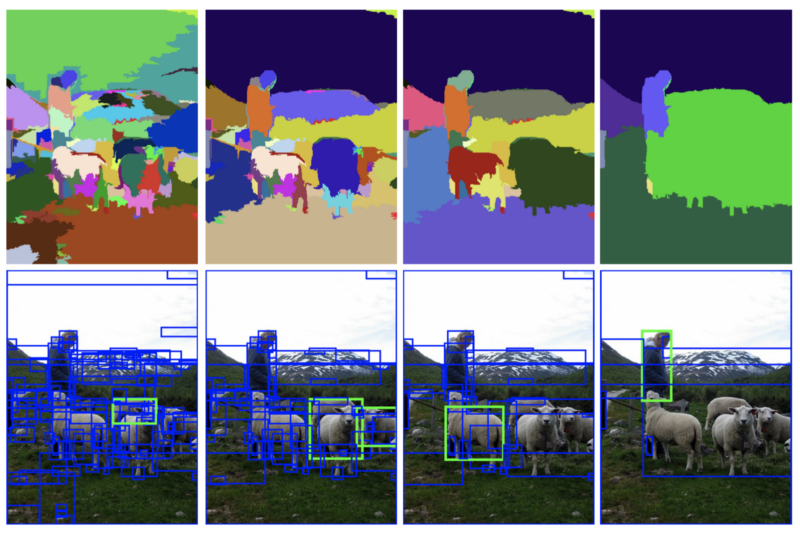 Example of search selective. Source: J.R.R. Uijlings and al. (2012)


-Fast R-CNN: Cette méthode avance d'un autre pas par rapport à R-CNN. Au lieu d'appliquer le CNN aux régions proposées par le SS(Search selective)n on commence plûtot par appliquer le CNN à l'input Image et puis appliquer le SS. Intuitivement, on connaît que les CNNs, donnent dans leurs sorties les résultats de l'application de filtres à une image donnée. L'output d'un CNN encode d'une façon ou d'une autre la précisions de quelques caratéristiques dans une région donné. Ceci justifie cette inversion de rôle.

-Faster R-CNN: Il s'agit ici à peu près le même principe que le Fast R-CNN mais avec en remplaçant le SS par le RPN(Region proposal Network). On va étudier cet algorithme en détail plus loin dans cette étude.

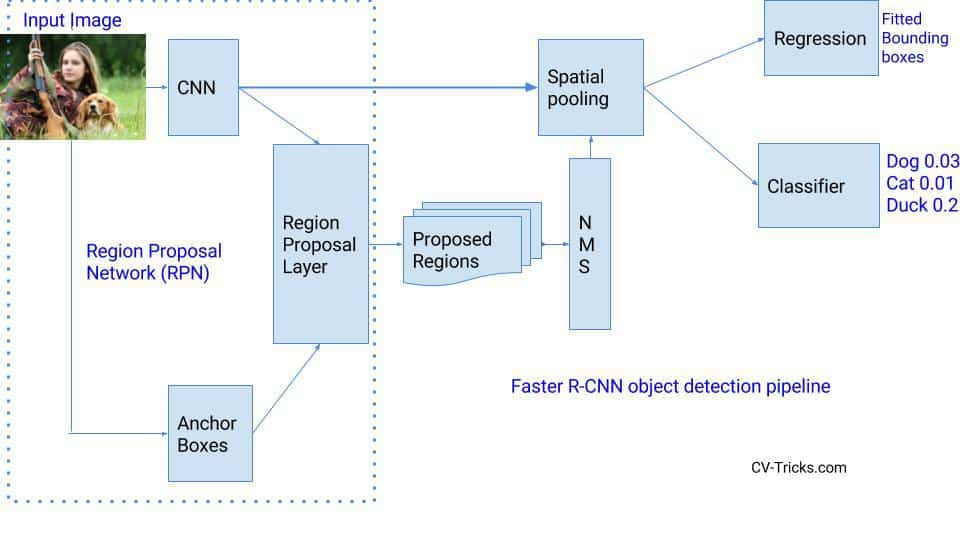

-SSD

-Yolo: Pour Yolo, le problème de détection se réduit à un problème de regression qui prend des images et apprend à la fois les "Bounding boxes" et les probabilités de chaque classe. L'input image est vu UNE SEULE FOIS par un CNN ce qui justifie à la fois l'appelation Yolo (YOu only look once) et la rapidité de Yolo (Il donne des résultats en temps réel). Pour ces raisons, on a choisi d'implémenter Yolo dans notre robot. L'algorithme étant en Open Source, on essaiera de l'adapter plus tard pour notre problème après avoir bien explorer ses principes.





Plan de notre étude: 

1- Convolutional Neural Networks :
      -Différentes implémentations sur Keras (Backend in Tensorflow) pour notre problème de classification (Cas du Robot Maryam) : Implémenter en Scratch / 
      -Validation de ces implémentations (Simple Hold-out Validation, K-FOLD Validation)
      -Résoudre le problème de "Overfitting" (Network size, Weight regularization, Droupout)
      
2- Faster R-CNN / SSD / Yolo : Etude quantitative de performances (A la fois sur les vidéos prises par notre équipe et par la Open Image dataset de Google)

3- Remarques et critiques / Pistes d'amélioration



1- Convolutional Neural Networks: 

Dans cette section, on va coder et entraîner des CNNs sur Keras (Backend in Tensorflow) pour réaliser la tâche de classification d'images. Dans notre étude on se restreindra sur un nombre limité de classes : Person, Table, Car, Motocycle (Des classes utiles pour notre problème).

On utilisera comme référence la DataSet CIFAR-100 qui contient 50 000 training image de dimension (28,28,3) et 10 000 test images. Au total, on compte 100 classes différentes. On se contentera de seulement 4 classes.

L'avantage de cette classe est qu'elle est déjà manipulable sur Keras ce qui facilite l'étape de la préparation de données.


1-1- Une version Naîve de la classification :

Remarques ( a jouter apres)

Importation des packages nécssaires

In [19]:
from keras.datasets import cifar100
from keras.utils import to_categorical



Preprocessing de la Dataset : Préparation pour le traitement

In [20]:

from keras.datasets import cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

EOFError: Ran out of input

In [42]:

from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(28, 28, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

On construit notre réseaux CNN, l'initialisation des tailles de chaque couche étant un peu arbitraire. On va ré-entrainer notre réseaux plusieurs fois pour ajuster (Dans un premier temps ces paramètres)
Voici l'architecture de notre model:

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1180160   
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 2052      
Total para

In [44]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [45]:
model.fit(train_images,train_labels,epochs=5,batch_size=64)

ValueError: Error when checking input: expected conv2d_20_input to have 4 dimensions, but got array with shape (60000, 28, 28)

On peut s'amuser à répéter cette procédure plusieurs fois en changeant l'architecture de notre modèle. Cette méthode est connue sous forme de Fine-tuning. 